In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

In [53]:
z_bin_centre = 2.0
z_bin_width = 0.2
z_bin = (z_bin_centre-z_bin_width/2,z_bin_centre+z_bin_width/2)
beta = 1.0

In [54]:
#Get the gaussian delta skewers
h = fits.open('/Users/jfarr/Projects/test_data/process_output_G_hZ_4096_32_sr2.0_bm1_nside8/2/276/picca-gaussian-8-276.fits')
delta_G_rows = h[0].data.T
IVAR_rows = h[1].data.T
#delta_G_rows = delta_G_rows[0,:]

#Trim the skewers to a narrow window around the z value selected
#Get the growth factor and any other useful things
master = fits.open('/Users/jfarr/Projects/test_data/process_output_G_hZ_4096_32_sr2.0_bm1_nside8/nside_8_master.fits')
D = master[2].data['D'][-571:]
Z = master[2].data['Z'][-571:]
Z_QSO = h[3].data['Z']

first_valid_cell = np.argmax(Z>z_bin[0])
last_valid_cell = np.argmax(Z>z_bin[1]) - 1
valid_rows = Z_QSO>z_bin[0]

D = D[first_valid_cell:last_valid_cell]
Z = Z[first_valid_cell:last_valid_cell]
delta_G_rows = delta_G_rows[:,first_valid_cell:last_valid_cell]
delta_G_rows = delta_G_rows[valid_rows,:]
IVAR_rows = IVAR_rows[:,first_valid_cell:last_valid_cell]
IVAR_rows = IVAR_rows[valid_rows,:]
Z_QSO = Z_QSO[valid_rows]

print('we have {} skewers, each with {} cells'.format(delta_G_rows.shape[0],delta_G_rows.shape[1]))
print('actual z-range of cells: {:2.2f} < z < {:2.2f}'.format(np.min(Z),np.max(Z)))

we have 6539 skewers, each with 74 cells
actual z-range of cells: 1.92 < z < 2.10


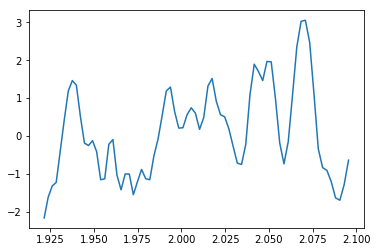

In [55]:
plt.plot(Z,delta_G_rows[np.argmax(Z_QSO),:])
plt.show()

In [102]:
def lognormal_transform(delta_G_rows,sigma_G,D):
    density_rows = np.zeros(delta_G_rows.shape)
    for j in range(delta_G_rows.shape[1]):
        D_j = D[j]
        density_rows[:,j] = np.exp(D_j*delta_G_rows[:,j]-(D_j**2)*(sigma_G**2)/2.)
    return density_rows

In [103]:
def get_mean_F_model(z):
    return np.exp((np.log(0.8))*((1+z)/3.25)**3.2)

In [134]:
def delta_G_to_delta_F(delta_G_rows,alpha,beta,D,sigma_G,IVAR_rows=None,mean_F=None):
    density_rows = lognormal_transform(delta_G_rows,sigma_G,D)
    F_rows = np.exp(-alpha*(density_rows**beta))
    if not mean_F:
        mean_F = np.average(F_rows,weights=IVAR_rows)
    delta_F_rows = F_rows/mean_F - 1
    return density_rows,F_rows,mean_F,delta_F_rows

In [167]:
def get_flux_stats(z,sigma_G,alpha,beta,delta_G_rows,IVAR_rows):

    density_rows,F_rows,mean_F,delta_F_rows = delta_G_to_delta_F(delta_G_rows,alpha,beta,D,sigma_G,IVAR_rows=IVAR_rows)
    """
    delta_G_data = np.reshape(delta_G_rows,delta_G_rows.shape[0] * delta_G_rows.shape[1])
    IVAR_data = np.reshape(IVAR_rows,IVAR_rows.shape[0]*IVAR_rows.shape[1])
    density_data = np.reshape(density_rows,density_rows.shape[0] * density_rows.shape[1])
    F_data = np.reshape(F_rows,F_rows.shape[0] * F_rows.shape[1])
    delta_F_data = np.reshape(delta_F_rows,delta_F_rows.shape[0] * delta_F_rows.shape[1])
    
    relevant_cells = IVAR_data>0
    delta_G_data = delta_G_data[relevant_cells]
    density_data = density_data[relevant_cells]
    F_data = F_data[relevant_cells]
    delta_F_data = delta_F_data[relevant_cells]
    """
    delta_G_integral = np.linspace(-20,20,10**5)
    delta_G_integral = np.reshape(delta_G_integral,(1,delta_G_integral.shape[0]))
    D_integral = (D[np.argmax(Z>z_bin_centre)])*np.ones(delta_G_integral.shape[1])
    
    density_integral,F_integral,_,delta_F_integral = delta_G_to_delta_F(delta_G_integral,alpha,beta,D_integral,sigma_G,mean_F=mean_F)    
    
    prob_delta_G = (1/(np.sqrt(2*np.pi)*sigma_G))*np.exp(-(delta_G_integral**2)/(2*sigma_G**2))
    
    plt.scatter(delta_G_integral,F_integral)
    plt.show()
    
    sigma_F = np.sqrt(np.trapz(prob_delta_G*delta_F_integral,delta_G_integral)[0])
    
    return mean_F, sigma_F

In [168]:
sigma_G_values = np.linspace(2,2,1)
print('{} <= sigma_G <= {}'.format(np.min(sigma_G_values),np.max(sigma_G_values)))
print('{} values of sigma_G will be tested'.format(sigma_G_values.shape[0]))

2.0 <= sigma_G <= 2.0
1 values of sigma_G will be tested


mean F model 0.8413721721350615



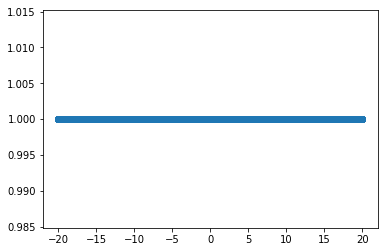

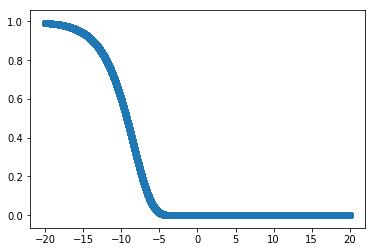

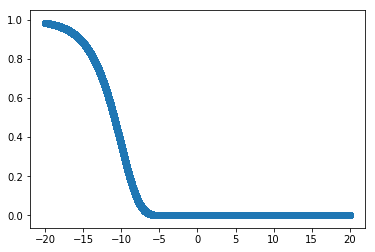

model: 0.84, (0.00,50.00,100.00), (1.00,0.00,0.00), (0.00,17.40,122.90)


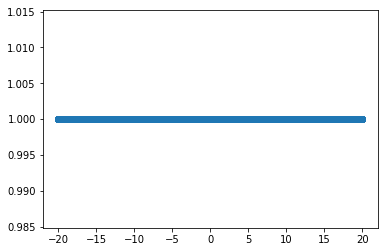

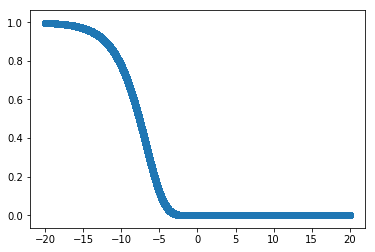

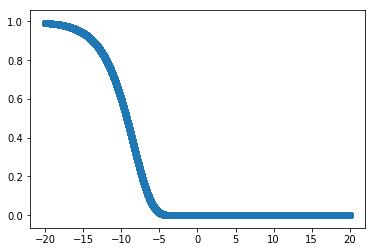

model: 0.84, (0.00,25.00,50.00), (1.00,0.00,0.00), (0.00,5.21,17.40)


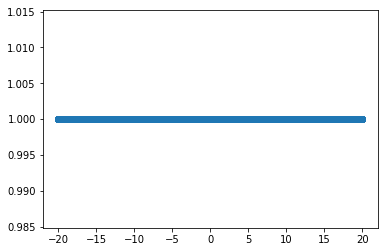

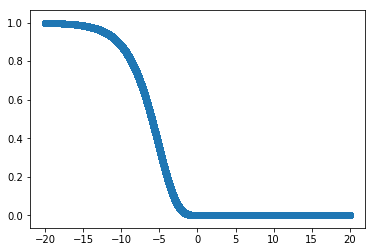

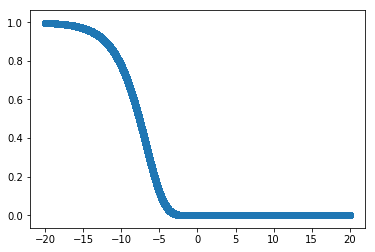

model: 0.84, (0.00,12.50,25.00), (1.00,0.00,0.00), (0.00,2.22,5.21)


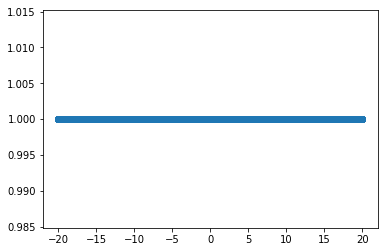

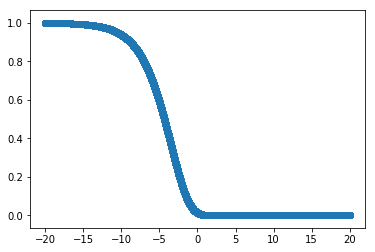

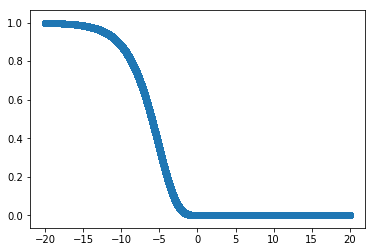

model: 0.84, (0.00,6.25,12.50), (1.00,0.03,0.00), (0.00,1.12,2.22)


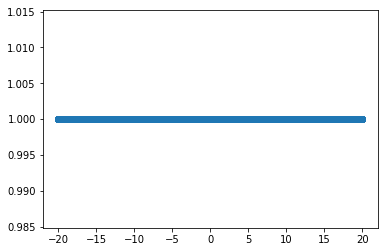

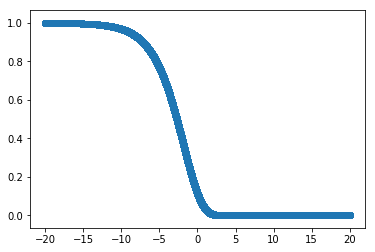

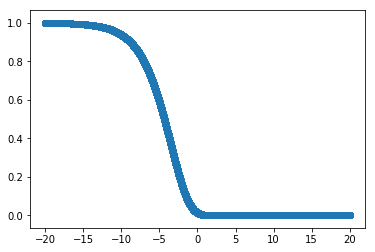

model: 0.84, (0.00,3.12,6.25), (1.00,0.13,0.03), (0.00,0.58,1.12)


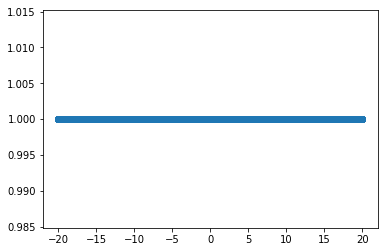

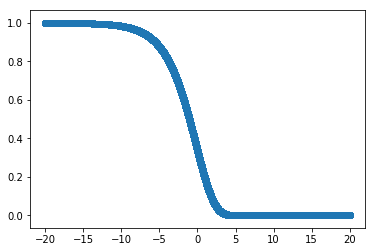

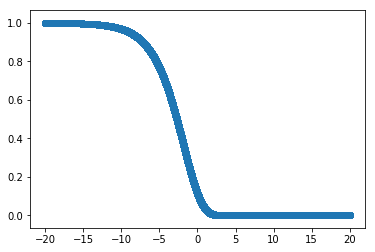

model: 0.84, (0.00,1.56,3.12), (1.00,0.33,0.13), (0.00,0.24,0.58)


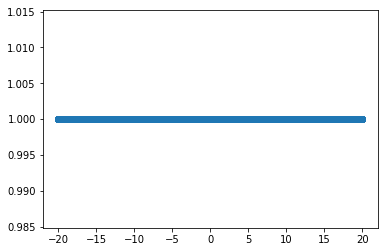

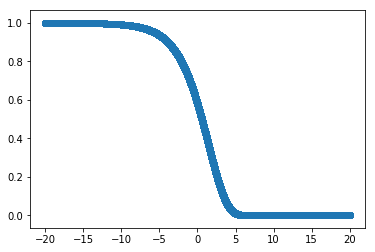

/Users/jfarr/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in sqrt


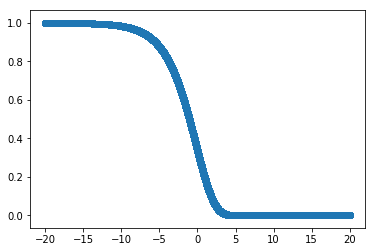

model: 0.84, (0.00,0.78,1.56), (1.00,0.56,0.33), (0.00,nan,0.24)


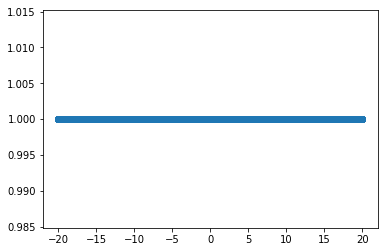

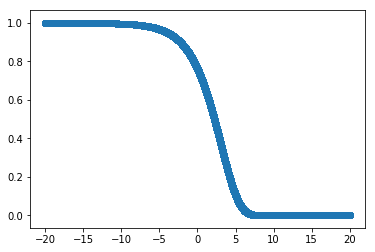

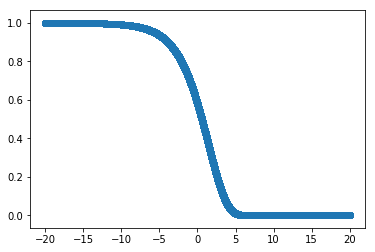

model: 0.84, (0.00,0.39,0.78), (1.00,0.74,0.56), (0.00,nan,nan)


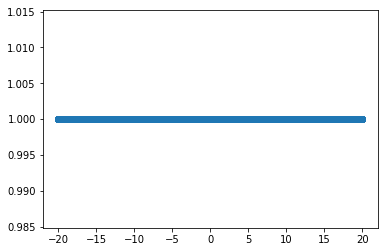

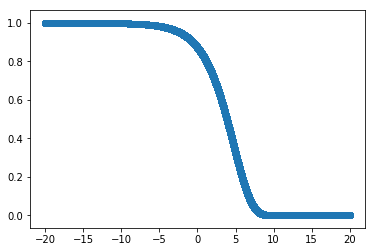

KeyboardInterrupt: 

In [169]:
tolerance = 0.0001

mean_F_model = get_mean_F_model(z_bin_centre)
print('mean F model {}\n'.format(mean_F_model))

for sigma_G in sigma_G_values:
    
    alpha_low = 0.0
    alpha_high = 100.0
    
    count = 0
    exit = 0
    
    while exit == 0 and count < 20:
        alpha_midpoint = (alpha_low + alpha_high)/2.0

        mean_F_al,sigma_F_al = get_flux_stats(z_bin_centre,sigma_G,alpha_low,beta,delta_G_rows,IVAR_rows)
        mean_F_am,sigma_F_am = get_flux_stats(z_bin_centre,sigma_G,alpha_midpoint,beta,delta_G_rows,IVAR_rows)
        mean_F_ah,sigma_F_ah = get_flux_stats(z_bin_centre,sigma_G,alpha_high,beta,delta_G_rows,IVAR_rows)

        print('model: {:2.2f}, ({:2.2f},{:2.2f},{:2.2f}), ({:2.2f},{:2.2f},{:2.2f}), ({:2.2f},{:2.2f},{:2.2f})'.format(mean_F_model,alpha_low,alpha_midpoint,alpha_high,mean_F_al,mean_F_am,mean_F_ah,sigma_F_al,sigma_F_am,sigma_F_ah))
        if np.sign(mean_F_al-mean_F_model) * np.sign(mean_F_am-mean_F_model) > 0:
            alpha_low = alpha_midpoint
        else:
            alpha_high = alpha_midpoint
                
        if abs(mean_F_am/mean_F_model - 1) < tolerance:
            exit = 1
        else:
            count += 1
            
        alpha = alpha_midpoint
        mean_F = mean_F_am
        sigma_F = sigma_F_am
    
    print('sigma G {:2.2f}, alpha {:2.2f}: mean F {:2.4f}, sigma F {:2.4f}, n {:3d}'.format(sigma_G,alpha,mean_F,sigma_F,count))